In [1]:
# Useful imports and setup
import sys
import os
# Necessary to import code from ../scripts/
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/scripts")
    
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns 
import time
import glob
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.metrics import balanced_accuracy_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from preprocessing import preprocess
from visualization import *
from cluster import *

%load_ext autoreload
%autoreload 2

data_path = '../data/'

feature_types = ['lalle_conati', 'boroujeni_et_al', 'chen_cui', 'marras_et_al']
metadata = pd.read_csv(data_path + 'metadata.csv')

### Spectral Clustering 

Using euclidean distance. You can tune the clustering by changing the gamma list.

In [ ]:
gamma_list = [0.6]
percentile_list = [0.4]

for course in ['hwts_001']:
    print(course)
    
    MODEL_PATH = '../models/saved/' + course + '/'
    
    clustering_method = 'spectral_clustering'
    labels_path = '../labels/' + course + '/' + clustering_method + '/inter-c3/'
    results_path = '../results/' + course + '/inter-c3/'

    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    if not os.path.exists(labels_path):
        os.makedirs(labels_path)

    if not os.path.exists(results_path):
        os.makedirs(results_path)

    path = data_path + course + '/'
    
    df = {}
    df['course'] = []
    df['norm'] = []
    df['sparsity'] = []
    df['number_clusters'] = []
    df['silhouette_score'] = []
    df['labels'] = []
    
    # Retrieve all configurations of masking models from the directory where they are saved
    norm_sparsity = {}
    norm_sparsity['unit'] = []
    norm_sparsity['min-max'] = []
    for f in glob.glob(MODEL_PATH+'*.index'):
        f = f.replace(MODEL_PATH, '').replace('.index', '').replace('annealing_fg_', '')
        f = f.split('_')
        if f[0] == 'unit' or f[0] == 'min-max':
            norm_sparsity[f[0]].append(float(f[2]))
    
    norm_sparsity['unit'].sort()
    norm_sparsity['min-max'].sort()
    
    for percentile in percentile_list:
        for norm in norm_sparsity.keys():
            for sparsity in list(np.unique(norm_sparsity[norm])):
                print('\nClustering course {0} using {1} normalization and {2} sparsity target'.format(course, 
                                                                                                       norm,
                                                                                                       sparsity))
                filename = 'annealing_fg_'+norm+'_norm_'+str(sparsity)+'_perc_'+str(percentile)
                # If you want to cluster considering the features not selected as important as beign NANs 
                # you just have to change the function bellow to "get_truncated_features_nan"
                feature_names, masks, X_masked, _, Y = get_truncated_features(MODEL_PATH, filename, course, 
                                                                              path, percentile, feature_types, 
                                                                              metadata, norm)

                start_time = time.time()
                # Distance matrix computed by feature and then aggregated 
                D = compute_distance_matrix(X_masked, 'euclidean')
                print(D)
                for gamma in gamma_list:
                    S = np.exp(-gamma * D ** 2)
                    try:
                        # NaNs in the similarity matrix may occur, especially in very sparse data, 
                        # causing potential issues when running eigengap heuristic
                        n_clusters = eigengap(S)
                    except:
                        print('Problem found in course {0} using {1} normalization and {2} sparsity target'.format(course, 
                                                                                                                   norm,
                                                                                                                   sparsity))
                        continue

                    n = 0
                    for i in n_clusters:
                        if i > 2: # selects more than 2 clusters
                            n = i
                            break

                    labels = np.array(spectral_clustering(n).fit_predict(S))
                    s_score = silhouette_score(D, labels, metric='precomputed')
                    print("Found {0} clusters with {1} silhouette score".format(n, s_score))
                    df['course'].append(course)
                    df['norm'].append(norm)
                    df['sparsity'].append(sparsity)
                    df['silhouette_score'].append(s_score)
                    df['number_clusters'].append(n)
                    df['labels'].append(labels)

                    np.savetxt(labels_path+'cluster_'+norm+'_norm_'+str(sparsity)+'_perc_'+str(percentile)+'_gamma_'+str(gamma)+'.txt', labels, fmt='%d')

                print('Time spent on clustering: {0}\n'.format(time.time() - start_time))
    df = pd.DataFrame(df)
    # Save clusters information per course
    pd.to_pickle(df, results_path+'clusters_info.pkl') 

In [2]:
percentile = 0.4
norm = 'unit'
course = 'dsp_001'
path = data_path + course + '/'
MODEL_PATH = '../models/saved/'+ course + '/'
labels_path = '../labels/' + course + '/spectral_clustering/inter-c3/'
filename = 'annealing_fg_unit_norm_0.5_perc_'+str(0.4)
feature_names, masks, X_masked, _, Y = get_truncated_features(MODEL_PATH, filename, course, path, percentile, feature_types, metadata, norm)

To generate the Sankey diagram, you need to train masks for each of the four percentiles (0.2, 0.4, 0.6, and 0.8) and subsequently perform clustering for all of them. Below, you can view the Sankey diagram for dsp_001:

In [104]:
create_sankey_diagram(labels_path, 'cluster_unit_norm_0.5_perc_', [0.2, 0.4, 0.6, 0.8], Y, gamma=True, g=0.6)

The following results are using only 40% of data for the course dsp_001.

In [3]:
# Get X_masked flatten
percentile = 0.4
feature_names, masks, X_masked, X, Y = get_truncated_features_flatten(MODEL_PATH, filename, course, path, percentile, feature_types, metadata, norm)

labels_path = '../labels/' + course + '/spectral_clustering/inter-c3/'
labels = np.loadtxt(labels_path+'cluster_unit_norm_0.5_perc_0.4_gamma_0.6.txt', dtype=int)

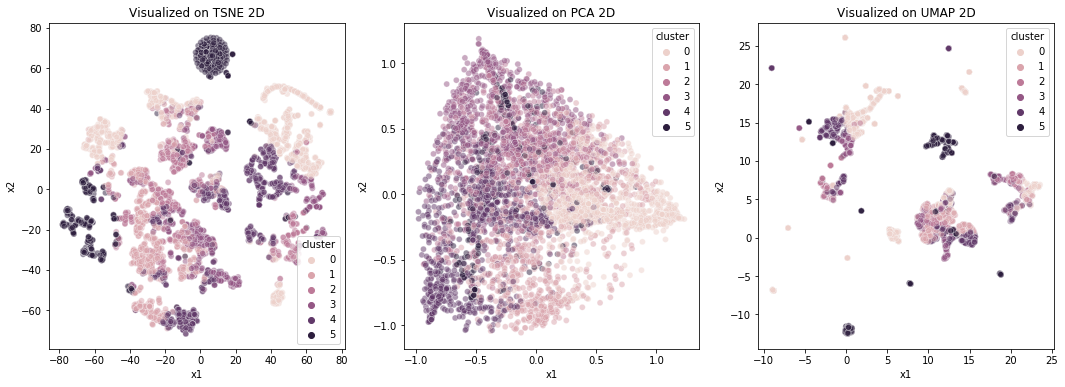

In [39]:
plot_tsne_and_pca(X_masked, labels)

In [4]:
from matplotlib import rc 

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{amssymb}')


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


A (786, 14.00819818214222, 60.43256997455471)
B (864, 15.398324719301373, 42.36111111111111)
C (762, 13.580466939939404, 30.577427821522306)
D (770, 13.723044020673678, 16.753246753246753)
E (1012, 18.036000712885404, 15.217391304347828)
F (1417, 25.253965425057924, 11.009174311926607)


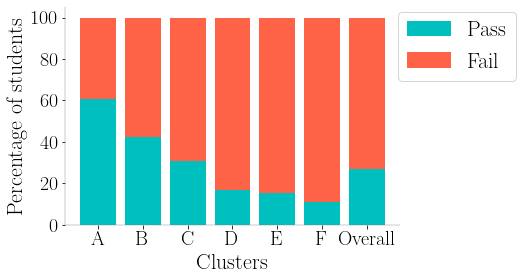

In [5]:
distributions_pass_fail(labels, Y, "../images/unit/distribution_pass_fail_0.4.jpeg")

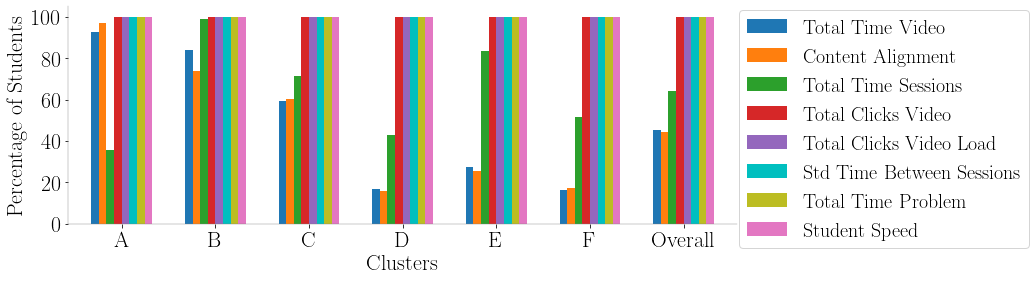

In [118]:
percentage_students_per_feature_grouped_bar(labels, masks, 
                                            list(feature_names_dict.values()), Y, 
                                            "../images/unit/percentage_per_feature.pdf")

['#2e8b57', '#517352', '#745b4c', '#964447', '#b92c41', '#dc143c', 'darkgrey']


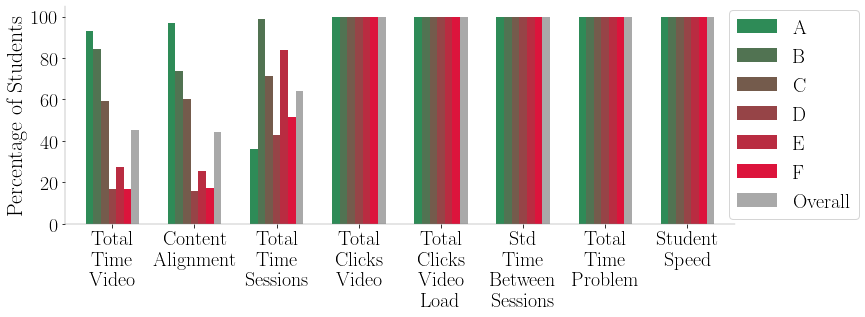

In [53]:
percentage_students_per_feature_grouped_bar_shiffted(labels, masks, 
                                            list(feature_names_dict.values()), Y, 
                                            "../images/unit/percentage_per_feature.pdf")

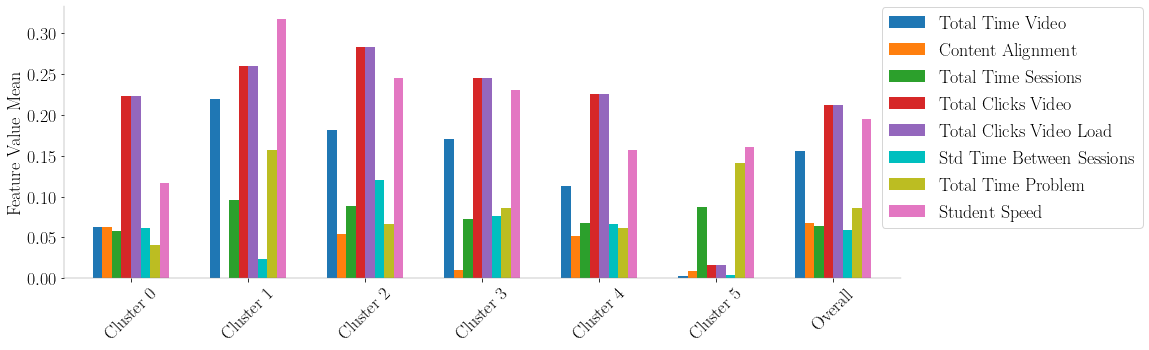

In [32]:
feature_value_grouped_bar(labels, masks, 
                          list(feature_names_dict.values()), X, Y, 
                          "../images/unit/feature_value.pdf")

['#2e8b57', '#586f46', '#825334', '#ab3823', '#d51c11', '#ff0000', 'darkgrey']


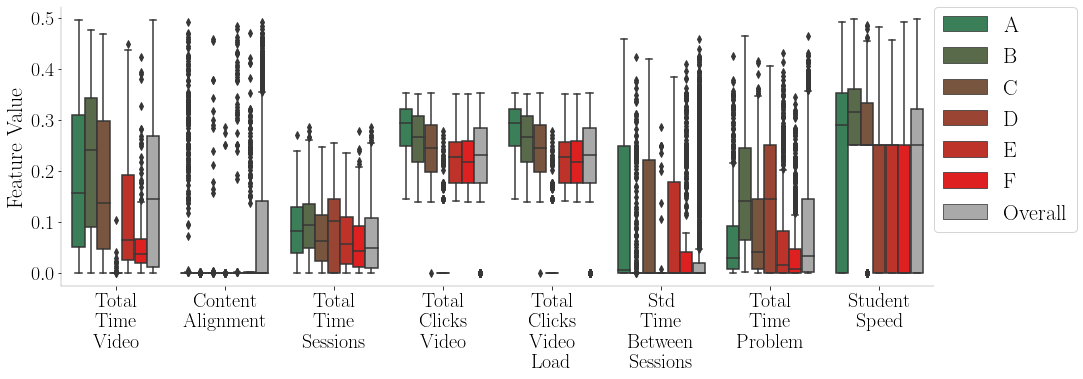

In [52]:
feature_value_boxplot_shiffted(labels, masks, 
                          list(feature_names_dict.values()), X, Y, 
                          "../images/unit/feature_value_boxplot.pdf")

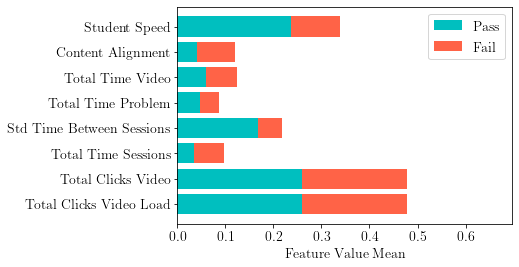

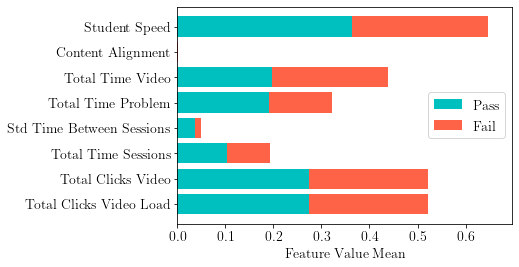

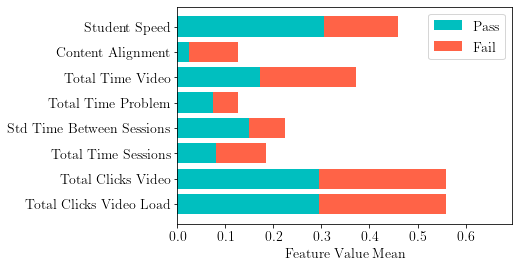

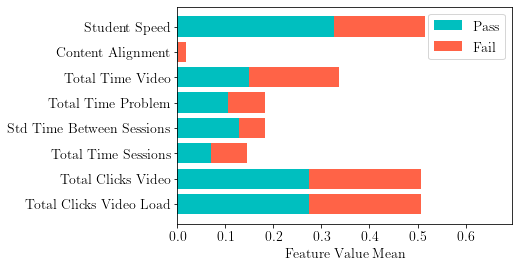

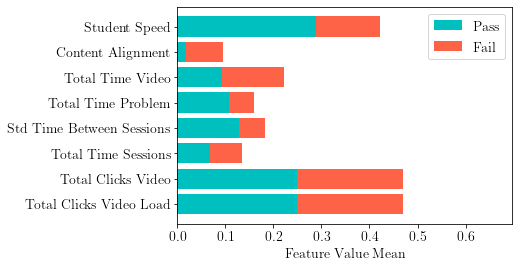

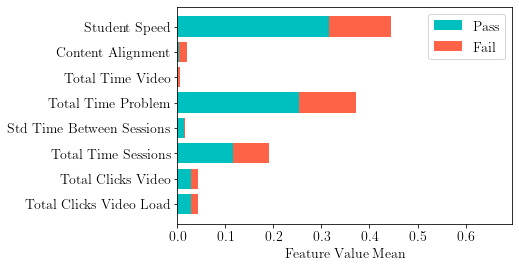

In [20]:
feature_value(labels, masks, list(feature_names_dict.values()), X, Y)

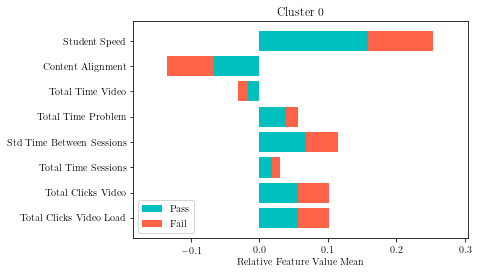

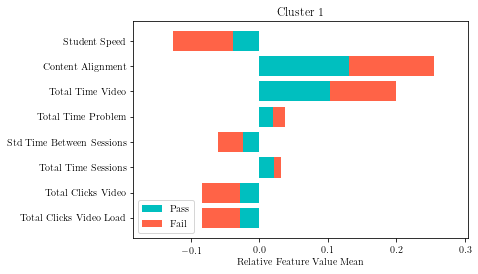

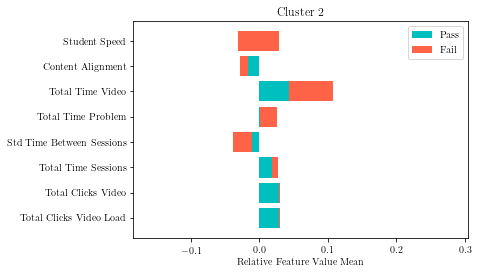

In [210]:
df = relative_feature_value(labels, masks, list(feature_names_dict.values()), X, Y)

In [212]:
df

,Feature,Avg Value,Max Value,Min Value
0,Total Clicks Video Load,0.212236,0.706994,0.0
1,Total Clicks Video,0.212236,0.706994,0.0
2,Total Time Sessions,0.063976,0.755853,0.0
3,Std Time Between Sessions,0.058829,0.999924,0.0
4,Total Time Problem,0.085774,1.000000,0.0
5,Total Time Video,0.156102,0.999999,0.0
6,Content Alignment,0.068019,1.000000,0.0
7,Student Speed,0.194622,1.000000,0.0


### Compute feature importance and save

In [43]:
df_importance = pd.DataFrame()
for c in range(np.max(labels)+1):
    cluster = np.where(labels == c)[0]
    f_activated = tf.reduce_sum(tf.gather(masks, list(cluster)), axis=0)
    feature_importance = {}
    for i in tf.where(f_activated)[:, 0]:
        feature_importance[feature_names[i]] = f_activated[i].numpy()/len(cluster)
    aux = pd.DataFrame(feature_importance, index=[c])
    df_importance = pd.concat([df_importance, aux])

In [44]:
df_importance

,total_clicks_Video.Load,total_clicks_Video,time_sessions sum,time_between_sessions std,time_in__problem sum,time_in__video sum,content_alignment,student_speed
0,1.0,1.0,0.515173,1.0,1.0,0.165138,0.172195,1.0
1,1.0,1.0,0.989583,1.0,1.0,0.841435,0.737269,1.0
2,1.0,1.0,0.358779,1.0,1.0,0.928753,0.970738,1.0
3,1.0,1.0,0.712598,1.0,1.0,0.591864,0.601050,1.0
4,1.0,1.0,0.836957,1.0,1.0,0.275692,0.255929,1.0
5,1.0,1.0,0.428571,1.0,1.0,0.166234,0.158442,1.0


In [47]:
results_path = '../results/' + course + '/inter-c3/'+ norm

if not os.path.exists(results_path):
        os.makedirs(results_path)

In [48]:
df_importance.to_csv(results_path+'/features_importance.csv', index=False)